In [1]:
import pandas as pd
import json
import os
import json
import wandb
import seaborn as sns
%matplotlib notebook

# Instance Model Results

In [2]:
model_dir = f"{os.environ['MINERVA_HOME']}/models/minerva_instance_models"

instance_model_res = {}
for split in ["val", "test"]:
    with open(f"{model_dir}/{split}_results.json") as f:
        instance_model_res[split] = json.load(f)
df = pd.DataFrame.from_dict(instance_model_res)

for row in df.itertuples():
    print(f"{row.Index.replace('eval_', '').capitalize()} & {row.val:.2} & {row.test:.2} \\\\")

Epoch & 5.5e+01 & 5.5e+01 \\
Accuracy & 0.85 & 0.82 \\
F1 & 0.86 & 0.82 \\
Loss & 1.5 & 1.9 \\
Positive_f1 & 0.65 & 0.6 \\
Precision & 0.89 & 0.84 \\
Recall & 0.85 & 0.82 \\
Runtime & 0.42 & 0.59 \\
Samples_per_second & 5.9e+02 & 4.7e+02 \\
Steps_per_second & 4.7 & 5.1 \\


# Baselines

In [3]:
baseline_dir = f"{os.environ['MINERVA_HOME']}/models/baselines"
baselines = {}
for file in os.listdir(baseline_dir):
    baseline_name = file.split(".")[0]
    with open(f"{baseline_dir}/{file}") as f:
        baselines[baseline_name] = json.load(f)


# MIL Sweep

Load training experiments from Wandb API

In [4]:
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("aadelucia/Minerva", filters = {"group": "MIL-Min10-v2"})

summary_list, config_list, name_list = [], [], []
data = []
for run in runs: 
    row = {}
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    row.update({k:v for k,v in run.summary._json_dict.items()})
    
    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    row.update({k: v for k,v in run.config.items() if not k.startswith('_')})
    
    # .name is the human-readable name of the run.
    row["name"] = run.name
    
    # Add 
    data.append(row)

runs_df = pd.DataFrame(data)

How does key instance ratio effect the performance? And how does performance compare to the baselines?

<IPython.core.display.Javascript object>


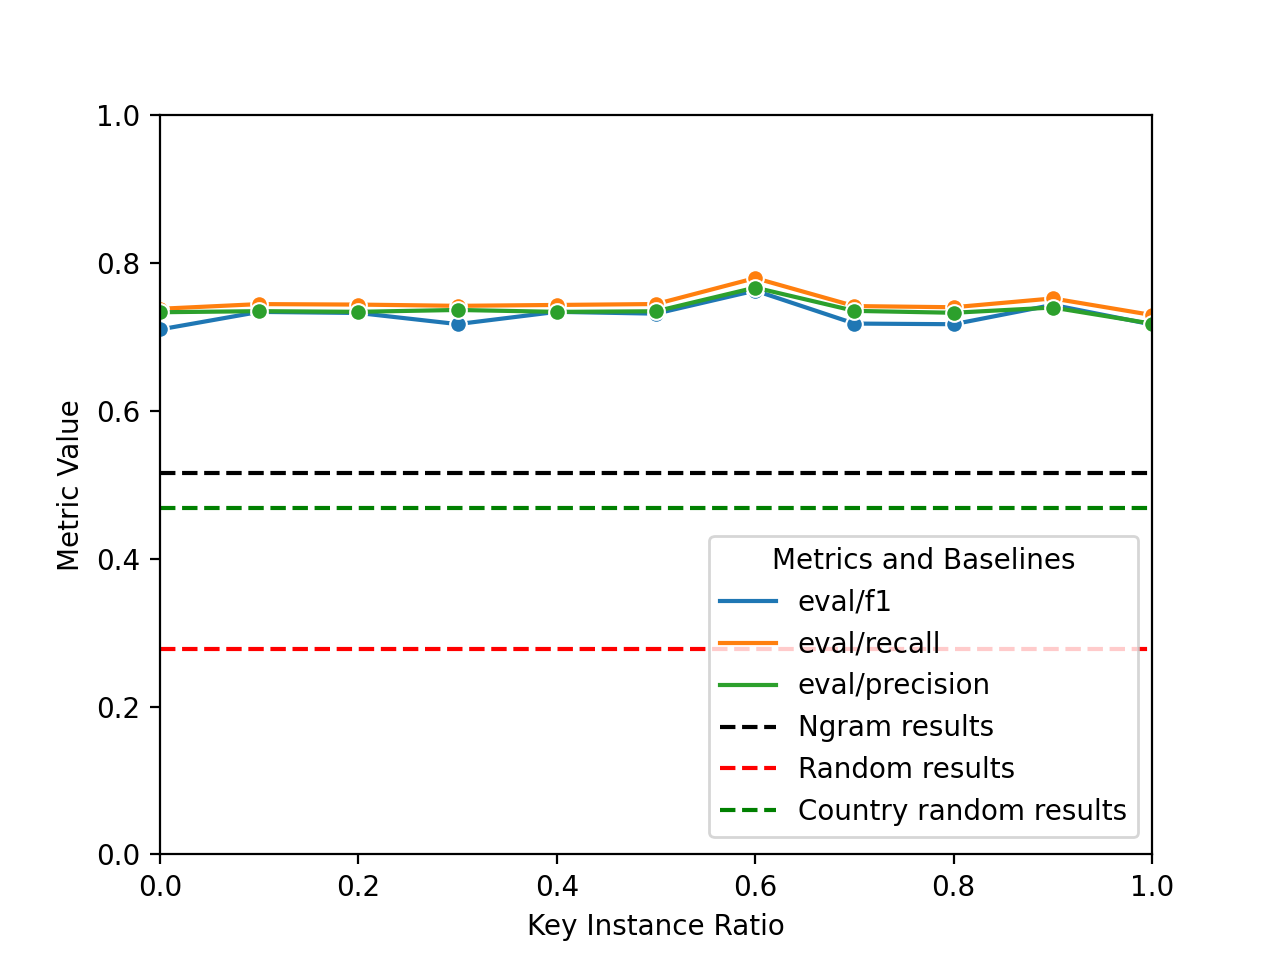

In [10]:
d = pd.melt(
    runs_df, 
    id_vars=["key_instance_ratio"], 
    value_vars=["eval/f1", "eval/recall", "eval/precision"],
    var_name="Metric",
    value_name="Value"
)

g = sns.lineplot(d, x="key_instance_ratio", y="Value", hue="Metric", marker="o")
g.set(ylim=(0, 1), xlim=(0, 1))
g.set_xlabel("Key Instance Ratio")
g.set_ylabel("Metric Value")

# Add baseline F1
colors = ["black", "red", "green", "yellow"]
for i, (b_name, res) in enumerate(baselines.items()):
    b_name = " ".join(b_name.split("_"))
    g.axhline(y=res['eval']['f1'], label=b_name.capitalize(), linestyle="--", color=colors[i])

# Update legend
g.legend(title="Metrics and Baselines", loc="upper right", bbox_to_anchor=(1, 0.45))


Table version of the same results. Include

- All baselines
- F1, precision, and recall
- Best MIL run
- MIL max run (i.e, key instance ratio of 0)


In [49]:
out = ""
summary = pd.concat([
    runs_df[runs_df.key_instance_ratio==0],
    runs_df.sort_values(by="eval/f1", ascending=False).iloc[0].to_frame().transpose()
])
for idx, row in summary.iterrows():
    out += f"MIL (k={row['key_instance_ratio']}) & {row['eval/f1']:.2} & {row['eval/precision']:.2} & {row['eval/recall']:.2} \\\\\n"

for b_name, res in baselines.items():
    b_name = " ".join(b_name.split("_"))
    out += f"{b_name.capitalize()} & {res['eval']['f1']:.2} & {res['eval']['precision']:.2} & {res['eval']['recall']:.2} \\\\\n"

print(out)



MIL (k=0.0) & 0.71 & 0.73 & 0.74 \\
MIL (k=0.6) & 0.76 & 0.77 & 0.78 \\
Ngram results & 0.52 & 0.58 & 0.46 \\
Random results & 0.28 & 0.28 & 0.28 \\
Country random results & 0.47 & 0.47 & 0.46 \\

